In [1]:
! uv pip install -U langchain-tavily

Using Python 3.10.9 environment at: F:\code\ai\langgraph-learn\.venv
Resolved 43 packages in 1.86s
Audited 43 packages in 0.19ms


In [1]:
from dotenv import load_dotenv
load_dotenv()


True

## 定义Tool

In [3]:
from langgraph.types import Command, interrupt
from langchain_core.tools import tool

@tool
def human_assistance(query: str) -> str:
    """Request assistance from a human."""
    human_response = interrupt({"query": query})
    return human_response["data"]

In [5]:
from langchain_tavily import TavilySearch

tool = TavilySearch(max_results=2)
tools = [tool,human_assistance]
# tool.invoke("What's a 'node' in LangGraph?")



## 定义Graph

In [9]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

In [5]:
! uv pip install -U "langchain[openai]"

Using Python 3.10.9 environment at: F:\code\ai\langgraph-learn\.venv
Resolved 39 packages in 1.76s
Audited 39 packages in 0.22ms


### llm绑定tools
这一步是让llm知道有哪些工具可以使用

In [10]:
from langchain_openai import ChatOpenAI
import os

llm = ChatOpenAI(model="qwen-plus-latest",base_url="https://dashscope.aliyuncs.com/compatible-mode/v1", 
        api_key=os.getenv("DASHSCOPE_API_KEY"),
        temperature=0)

llm_with_tools = llm.bind_tools(tools)

In [12]:

def chatbot_node(state: State):
    message = llm_with_tools.invoke(state["messages"])
    assert len(message.tool_calls) <= 1
    return {"messages": [message]}

graph_builder.add_node("chatbot", chatbot_node)

## 创建tool函数
graph中的运行单元都是一个node，以函数的形式存在，tool也不例外,所以要创建一个函数来运行这个tool。
为此langgraph的prebuilt包下封装了一个ToolNode

In [13]:
from langgraph.prebuilt import ToolNode

graph_builder.add_node("tools", ToolNode(tools=tools))

## 创建MemorySaver checkpointer

In [14]:
from langgraph.graph import END
from langgraph.prebuilt import tools_condition
from langgraph.checkpoint.memory import MemorySaver

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

## 可视化graph
您可以使用 get_graph 方法和其中一种“draw”方法（例如 draw_ascii 或 draw_png 来可视化图形。每种 draw 方法都需要额外的依赖项。

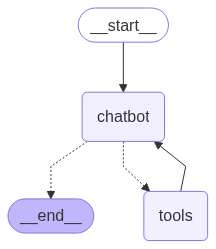

In [15]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

## 运行chatbot

In [16]:
user_input = "I need some expert guidance for building an AI agent. Could you request assistance for me?"
config = {
    "configurable": {
        "thread_id": "2",
    }
}

In [17]:
def stream_graph_updates(user_input: str):
    for event in graph.stream(
        {"messages": [{"role": "user", "content": user_input}]},
        config=config,
        stream_mode="values",
    ):
        if "messages" in event:
            event["messages"][-1].pretty_print()

In [18]:
stream_graph_updates(user_input)

================================ Human Message =================================

I need some expert guidance for building an AI agent. Could you request assistance for me?
================================== Ai Message ==================================
Tool Calls:
  human_assistance (call_5381e23688bf4f29a78e01)
 Call ID: call_5381e23688bf4f29a78e01
  Args:
    query: I need expert guidance for building an AI agent. Can someone assist me with this?


In [19]:
snapshot = graph.get_state(config)
snapshot.next

('tools',)